<a href="https://colab.research.google.com/github/tbirch4/chi-company-map-maker/blob/main/grant_park_greenery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!pip3 install --upgrade matplotlib # Required to use `bar_label`
from matplotlib import colors
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
plt.style.use('dark_background')
 
def get_image_data(img_path):
  """Read and prep image data.
  """
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = img.reshape((img.shape[1]*img.shape[0],3))
  # Drop transparent pixels.
  img = [pixel for pixel in img if ~np.all(pixel == 0)]
  return img

def create_clusters(input_data):
  """Apply k-means algorithm and return results.
  """
  km_output = KMeans(n_clusters=5).fit(input_data)

  labels = km_output.labels_

  km_stats = {
      'label_id': [], 'color_code': [], 
      'pixel_ct': [], 'pixel_pct': []}

  for i, label in enumerate(set(labels)):

    color_code = tuple(color/255 for color in km_output.cluster_centers_[i])
    pixel_ct = len([item for item in km_output.labels_ if item == label])
    pixel_pct = round(pixel_ct / len(km_output.labels_), 2)

    km_stats['label_id'].append(f'label_{label}')
    km_stats['color_code'].append(color_code)
    km_stats['pixel_ct'].append(pixel_ct)
    km_stats['pixel_pct'].append(pixel_pct)

  return km_stats, labels

def plot_clusters(cluster_data):
  """Plot cluster data.
  """
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.set_title('Cluster size as % of total pixels')
  p1 = plt.bar(
      data=cluster_data,
      x='label_id',
      height='pixel_pct',
      color='color_code')
  ax.bar_label(p1, label_type='edge', padding=2)
  plt.show()

def elbow_check(input_data):
  """Find ideal number of clusters.
  """
  cost =[]
  for i in range(1, 11):
      km_output = KMeans(n_clusters = i, max_iter = 500).fit(input_data)
      cost.append(km_output.inertia_)   
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.set_title('Elbow check for cluster count.')
  plt.plot(cost)
  plt.show() 
  return cost

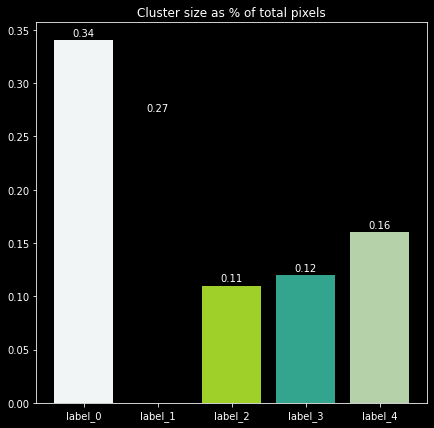

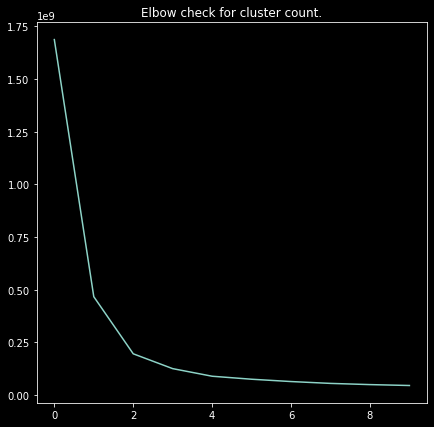

In [3]:
img1 = get_image_data('/content/grant_park_sat.png')
img2 = get_image_data('/content/grant_park_sat.png')
clusters, labels = create_clusters(img1)
plot_clusters(clusters)
elbow_output = elbow_check(img1)

In [4]:
import altair as alt
alt.themes.enable('dark')
import pandas as pd

clusters_df = pd.DataFrame(clusters)

color_domain = clusters_df['label_id'].unique()
color_range = clusters_df['color_code'].apply(lambda x: colors.to_hex(x))
color_range = color_range.unique()

alt.Chart(clusters_df).mark_bar().encode(
    y=alt.Y('label_id', title=None),
    x=alt.X('pixel_pct', title='% of pixels'),
    color=alt.Color('label_id', legend=None, 
                    scale=alt.Scale(domain=color_domain, range=color_range))
).properties(
    title='Cluster size as % of pixels',
    height=175,
    width=600
)

alt.Chart(...)

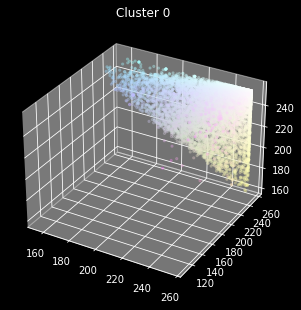

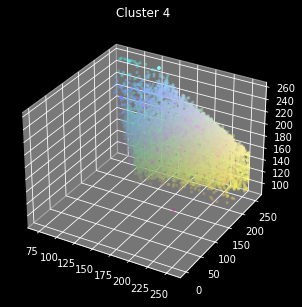

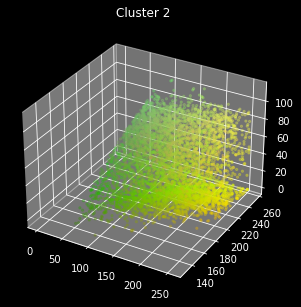

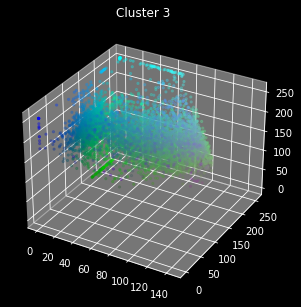

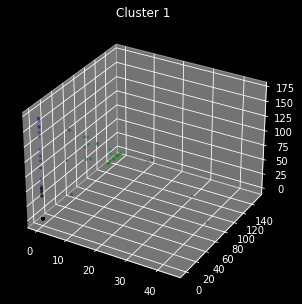

In [5]:
xdf = pd.concat(
    [pd.DataFrame(np.row_stack(img1)), pd.DataFrame(labels)], axis=1)
xdf.columns = ['red', 'green', 'blue', 'cluster']
for cluster in xdf['cluster'].unique():
  filter_df = xdf[xdf['cluster'] == cluster].copy()
  x = filter_df['red']
  y = filter_df['green']
  z = filter_df['blue']
  c = list(zip(filter_df['red'] / 255, 
               filter_df['green'] / 255, 
               filter_df['blue'] / 255))
  fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(5, 5))
  ax.set_title(f'Cluster {cluster}')
  ax.scatter(x, y, z, color=c, marker='.', alpha=0.3)
  plt.show()